#  Taller 4: Analisis de Redes con Python 

**Universidad Nacional de Colombia**  
*Facultad de Ciencias Agrarias*  
*Maestria en Geomática*  
*Geoprocesamiento*  

**Lecturer:** Jeanneth Perez Vallejo 

---
**Enlace imagen publicada en Docker hub:** https://hub.docker.com/r/rjperez319/grafos-espaciales 


### Librerias principales para el ejercicio

In [2]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import shapely
import matplotlib.pyplot as plt
import contextily as ctx


### Un ejemplo de lectura de datos y construcción de grafos 

[1, 2, 3]
[(1, 2)]


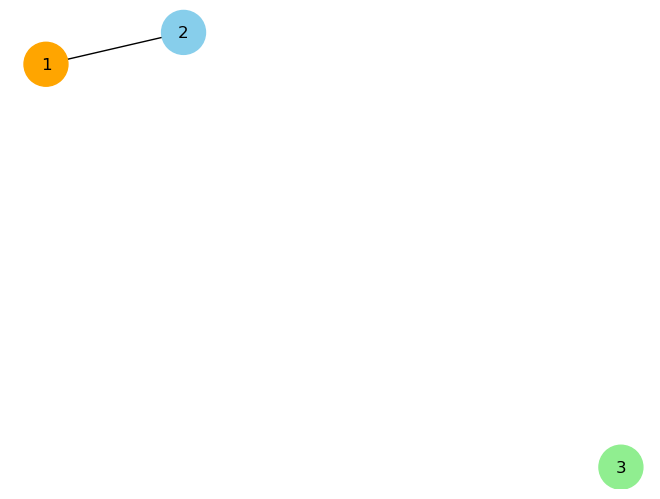

In [3]:
import networkx as nx

G = nx.Graph()

G.add_nodes_from([1, 2, 3])
G.add_edge(1, 2)

print(G.nodes())    # → [1, 2, 3]
print(G.edges())    # → [(1, 2)]

colors = ['orange', 'skyblue', 'lightgreen']  

# Dibujar el grafo con colores personalizados
nx.draw(G, with_labels=True, node_color=colors, node_size=1000)
plt.show()

### Vamos a realizar el analisis para la localidad de San Cristobal en Bogotá

#### Descarga de los datos 

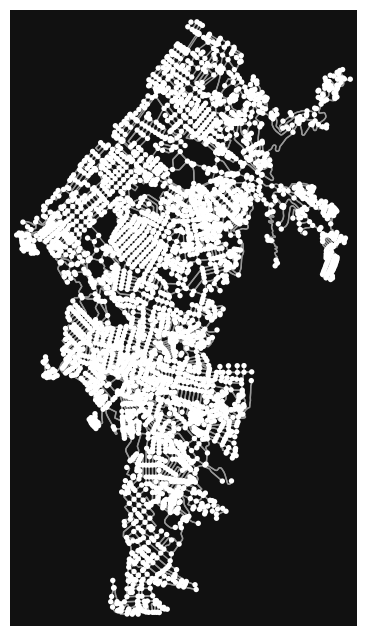

In [5]:
import osmnx


place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

place_polygon = place_polygon.to_crs("EPSG:3116")

place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84 (required by OSMnx)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the network graph
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="drive"
)

fig, ax = osmnx.plot_graph(graph)

### Obtener y explorar las calles de la red 

In [10]:
# Retrieve only edges from the graph
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid      highway lanes maxspeed  \
u          v          key                                           
261138271  9396102217 0      28412169    secondary     4       30   
           1928027437 0    1106580407    secondary     3      NaN   
9396102217 261138271  0      28412169    secondary     4       30   
           315395082  0      28693336  residential     2      NaN   
           5216582463 0      28412169    secondary     4       30   

                                         name  oneway reversed     length  \
u          v          key                                                   
261138271  9396102217 0    Avenida Carrera 10   False    False   7.291248   
           1928027437 0    Avenida Carrera 10    True    False  34.703477   
9396102217 261138271  0    Avenida Carrera 10   False     True   7.291248   
           315395082  0         Calle 35A Sur   False     True  16.820256   
           5216582463 0    Avenida Carrera 10   False    False  43.195812   

                                                                    geometry  \
u          v          key                                                      
261138271  9396102217 0    LINESTRING (599450.657 504756.531, 599445.983 ...   
           1928027437 0    LINESTRING (599450.657 504756.531, 599479.755 ...   
9396102217 261138271  0    LINESTRING (599445.983 504750.964, 599450.657 ...   
           315395082  0    LINESTRING (599445.983 504750.964, 599459.696 ...   
           5216582463 0    LINESTRING (599445.983 504750.964, 599429.987 ...   

                          bridge access junction  
u          v          key                         
261138271  9396102217 0      NaN    NaN      NaN  
           1928027437 0      NaN    NaN      NaN  
9396102217 261138271  0      NaN    NaN      NaN  
           315395082  0      NaN    NaN      NaN  
           5216582463 0      NaN    NaN      NaN

#### Explorando la red vial en San Cristobal 

#### contando los tipos de vias

In [21]:
edges["highway"].value_counts()

highway
residential       7873
tertiary          1330
secondary          661
primary             41
secondary_link      17
primary_link         3
unclassified         3
tertiary_link        1
Name: count, dtype: int64

#### Reproyectar la red

In [22]:

nodes = nodes.to_crs(epsg=9377)
edges = edges.to_crs(epsg=9377)
nodes.crs

<Projected CRS: EPSG:9377>
Name: MAGNA-SIRGAS 2018 / Origen-Nacional
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Coordinate Operation:
- name: Colombia Transverse Mercator
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia 2018
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### Calculando las estadisticas de la red

In [23]:
# Calculate network statistics
osmnx.basic_stats(graph)

{'n': 3712,
 'm': 9929,
 'k_avg': 5.349676724137931,
 'edge_length_total': 693736.3639895376,
 'edge_length_avg': 69.86971134953546,
 'streets_per_node_avg': 2.890625,
 'streets_per_node_counts': {0: 0, 1: 617, 2: 6, 3: 2271, 4: 803, 5: 14, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1662176724137931,
  2: 0.0016163793103448276,
  3: 0.6117995689655172,
  4: 0.21632543103448276,
  5: 0.003771551724137931,
  6: 0.00026939655172413793},
 'intersection_count': 3095,
 'street_length_total': 370992.0246165521,
 'street_segment_count': 5308,
 'street_length_avg': 69.89299634825774,
 'circuity_avg': 1.044241181069618,
 'self_loop_proportion': 0.0}

#### Calcular una envolvente para establecer el area que ocupa la red

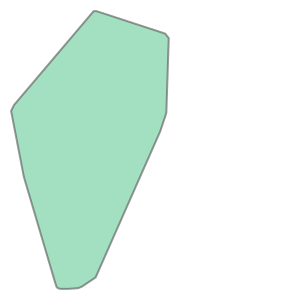

In [24]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

#### Calcular estadisticas usando una area real 

In [26]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 3712,
 'm': 9929,
 'k_avg': 5.349676724137931,
 'edge_length_total': 693736.3639895376,
 'edge_length_avg': 69.86971134953546,
 'streets_per_node_avg': 2.890625,
 'streets_per_node_counts': {0: 0, 1: 617, 2: 6, 3: 2271, 4: 803, 5: 14, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1662176724137931,
  2: 0.0016163793103448276,
  3: 0.6117995689655172,
  4: 0.21632543103448276,
  5: 0.003771551724137931,
  6: 0.00026939655172413793},
 'intersection_count': 3095,
 'street_length_total': 370992.0246165521,
 'street_segment_count': 5308,
 'street_length_avg': 69.89299634825774,
 'circuity_avg': 1.044241181069618,
 'self_loop_proportion': 0.0,
 'node_density_km': 147.98480508503732,
 'intersection_density_km': 123.38711523119356,
 'edge_density_km': 27656.907490677324,
 'street_density_km': 14790.1892378728}

In [28]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 3712,
 'm': 9929,
 'k_avg': 5.349676724137931,
 'edge_length_total': 693736.3639895376,
 'edge_length_avg': 69.86971134953546,
 'streets_per_node_avg': 2.890625,
 'streets_per_node_counts': {0: 0, 1: 617, 2: 6, 3: 2271, 4: 803, 5: 14, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1662176724137931,
  2: 0.0016163793103448276,
  3: 0.6117995689655172,
  4: 0.21632543103448276,
  5: 0.003771551724137931,
  6: 0.00026939655172413793},
 'intersection_count': 3095,
 'street_length_total': 370992.0246165521,
 'street_segment_count': 5308,
 'street_length_avg': 69.89299634825774,
 'circuity_avg': 1.044241181069618,
 'self_loop_proportion': 0.0,
 'node_density_km': 147.98480508503732,
 'intersection_density_km': 123.38711523119356,
 'edge_density_km': 27656.907490677324,
 'street_density_km': 14790.1892378728}

### Revisando la distancia entre puntos de la red

#### Se ubican dos lugares reales en la red usada, y se calculan las distancias entre sus nodos más cercanos.

In [ ]:
graph_proj = ox.project_graph(graph)

# Convertir a GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph_proj)

#  Geocodificar lugares y reproyectar
origin_gdf = ox.geocode_to_gdf("Hospital San Blas, Bogotá, Colombia").to_crs(edges.crs)
destination_gdf = ox.geocode_to_gdf("Colegio Antonio Nariño, Bogotá, Colombia").to_crs(edges.crs)

# Extraer puntos (centroides si son polígonos)
origin = origin_gdf.geometry.iloc[0].centroid
destination = destination_gdf.geometry.iloc[0].centroid


#### Obtener los nodos más cercanos entre estos dos lugares en la red

In [44]:
# Obtener nodos más cercanos
orig_node = ox.distance.nearest_nodes(graph_proj, X=origin.x, Y=origin.y)
dest_node = ox.distance.nearest_nodes(graph_proj, X=destination.x, Y=destination.y)

#### Calcular la ruta más corta entre ellos con:

🔴 Dijkstra

🟢 A*

🧭 Nodos seleccionados:
  Nodo de origen: 1326478310
  Coordenadas (X, Y): (601686.34, 505170.15)
  Nodo de destino: 266678317
  Coordenadas (X, Y): (599362.98, 518048.67)

📏 Distancias calculadas:
  Dijkstra: 3200.51 metros
  A*:       3200.51 metros
  Diferencia: 0.00 metros


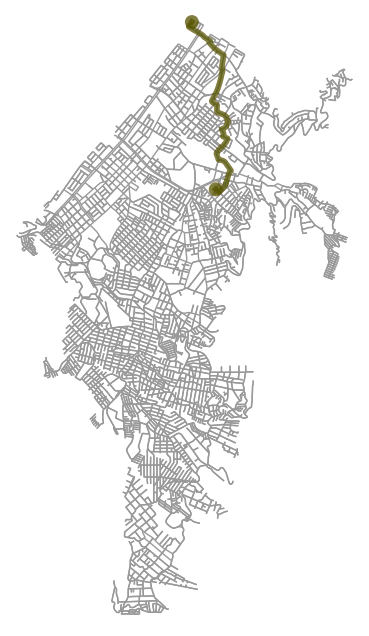

In [ ]:


# Validación: nodos distintos
if orig_node == dest_node:
    print("⚠️ Los nodos origen y destino son iguales. Verifica las ubicaciones.")
else:
    #  Calcular ruta Dijkstra
    ruta_dijkstra = nx.shortest_path(graph_proj, orig_node, dest_node, weight='length')
    distancia_dijkstra = nx.shortest_path_length(graph_proj, orig_node, dest_node, weight='length')

    #  Calcular ruta A*
    ruta_astar = nx.astar_path(graph_proj, orig_node, dest_node, weight='length')
    distancia_astar = nx.astar_path_length(graph_proj, orig_node, dest_node, weight='length')

    # Mostrar resultados
    print("🧭 Nodos seleccionados:")
    print(f"  Nodo de origen: {orig_node}")
    print(f"  Coordenadas (X, Y): ({origin.x:.2f}, {origin.y:.2f})")
    print(f"  Nodo de destino: {dest_node}")
    print(f"  Coordenadas (X, Y): ({destination.x:.2f}, {destination.y:.2f})\n")

    print("📏 Distancias calculadas:")
    print(f"  Dijkstra: {distancia_dijkstra:.2f} metros")
    print(f"  A*:       {distancia_astar:.2f} metros")
    print(f"  Diferencia: {abs(distancia_dijkstra - distancia_astar):.2f} metros")

    # 11. Visualización
    ox.plot_graph_routes(
        graph_proj,
        routes=[ruta_dijkstra, ruta_astar],
        route_colors=['red', 'green'],
        route_linewidth=4,
        node_size=0,
        bgcolor='white'
    )

### Calculo de ruta con un tercer algortimo 
##### Leer más aqui: https://www.w3schools.com/dsa/dsa_algo_graphs_bellmanford.php
##### El algoritmo genera el camino más corto en un grafo dirigido ponderado (en el que el peso de alguna de las aristas puede ser negativo).

In [49]:
#  Calcular ruta Bellman-Ford
ruta_bellman = nx.bellman_ford_path(graph_proj, orig_node, dest_node, weight='length')
distancia_bellman = nx.bellman_ford_path_length(graph_proj, orig_node, dest_node, weight='length')

#  Comparar resultados
print(f"Bellman-Ford: {distancia_bellman:.2f} metros")

Bellman-Ford: 3200.51 metros


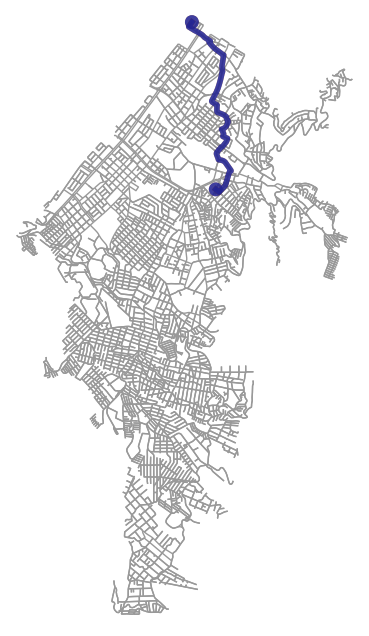

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [50]:
ox.plot_graph_routes(
    graph_proj,
    routes=[ruta_dijkstra, ruta_astar, ruta_bellman],
    route_colors=['red', 'green', 'blue'],
    route_linewidth=3,
    node_size=0,
    bgcolor='white'
)

### Comparación de varios algoritmos de calculo de la ruta más corta

📏 Distancias entre origen y destino:
  Dijkstra:             3200.51 m
  A*:                   3200.51 m
  Bellman-Ford:         3200.51 m
  BidirectionalDijkstra:3200.51 m


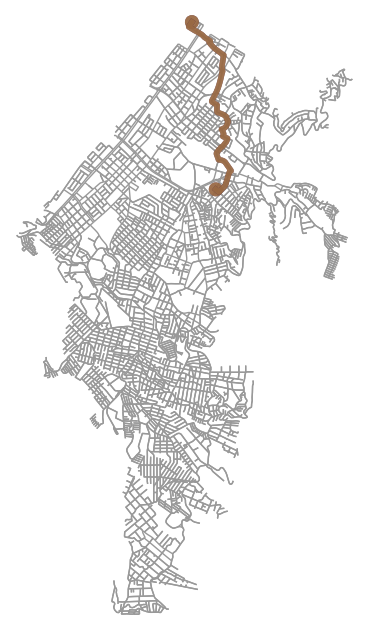

In [52]:
if orig_node == dest_node:
    print("⚠️ Origen y destino coinciden en el mismo nodo. Usa puntos más separados.")
else:
    # Dijkstra
    ruta_dijkstra = nx.shortest_path(graph_proj, orig_node, dest_node, weight='length')
    distancia_dijkstra = nx.shortest_path_length(graph_proj, orig_node, dest_node, weight='length')

    # A*
    ruta_astar = nx.astar_path(graph_proj, orig_node, dest_node, weight='length')
    distancia_astar = nx.astar_path_length(graph_proj, orig_node, dest_node, weight='length')

    # Bellman-Ford
    ruta_bellman = nx.bellman_ford_path(graph_proj, orig_node, dest_node, weight='length')
    distancia_bellman = nx.bellman_ford_path_length(graph_proj, orig_node, dest_node, weight='length')

    # Bidirectional Dijkstra
    distancia_bidir, ruta_bidir = nx.bidirectional_dijkstra(graph_proj, orig_node, dest_node, weight='length')

    # Mostrar resultados
    print("📏 Distancias entre origen y destino:")
    print(f"  Dijkstra:             {distancia_dijkstra:.2f} m")
    print(f"  A*:                   {distancia_astar:.2f} m")
    print(f"  Bellman-Ford:         {distancia_bellman:.2f} m")
    print(f"  BidirectionalDijkstra:{distancia_bidir:.2f} m")

    # Visualizar todas las rutas
    ox.plot_graph_routes(
        graph_proj,
        routes=[ruta_dijkstra, ruta_astar, ruta_bellman, ruta_bidir],
        route_colors=['red', 'green', 'blue', 'orange'],
        route_linewidth=3,
        node_size=0,
        bgcolor='white',
        show=True
    )


#### Dado que los resultados muestran que todos los algortimos calculan la misma distancia evaluemos ahora que nodo puede tener un peso mas relevante dentro de la red aunque esta se muestre consistente, a su vez podemos establecer el tiempo de eficiencia de cada algoritmo.

⏳ Calculando centralidad de intermediación (esto puede tardar)...


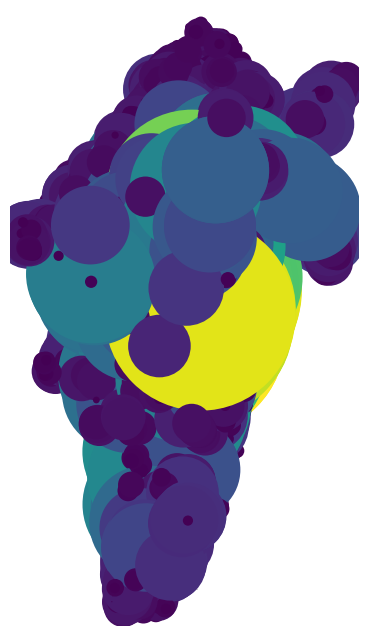

In [53]:
# Calcular centralidad de intermediación
print("⏳ Calculando centralidad de intermediación (esto puede tardar)...")
centralidad = nx.betweenness_centrality(graph_proj, weight='length', normalized=True)

# Asignar centralidad a los nodos como atributo
nx.set_node_attributes(graph_proj, centralidad, "betweenness")

# Visualizar con mapa de calor
node_color = [centralidad.get(n, 0) for n in graph_proj.nodes()]
node_size = [v * 100000 for v in node_color]  # Escalar tamaño

fig, ax = ox.plot_graph(
    graph_proj,
    node_size=node_size,
    node_color=node_color,
    node_zorder=2,
    edge_color="#cccccc",
    edge_linewidth=0.5,
    bgcolor="white",
    show=True
)

##### El resultado de betweenness centrality muestra un grafico donde cada círculo representa un nodo (una intersección vial). El tamaño del círculo indica cuán importante es ese nodo como intermediario en las rutas más cortas entre otros nodos.El nodo más grande y amarillo en el centro permite identificar el punto más crítico de toda la red, es decir, muchas rutas más cortas pasan por ese nodo. Puede representar una avenida o cruce principal en San Cristóbal o Bogotá (como Av. Caracas o Primero de Mayo).

### Calculando la eficiencia

In [54]:
import time
import pandas as pd

# Inicializar lista de resultados
resultados = []

# Dijkstra
t0 = time.time()
nx.shortest_path(graph_proj, orig_node, dest_node, weight='length')
t1 = time.time()
resultados.append(("Dijkstra", distancia_dijkstra, t1 - t0))

# A*
t0 = time.time()
nx.astar_path(graph_proj, orig_node, dest_node, weight='length')
t1 = time.time()
resultados.append(("A*", distancia_astar, t1 - t0))

# Bellman-Ford
t0 = time.time()
nx.bellman_ford_path(graph_proj, orig_node, dest_node, weight='length')
t1 = time.time()
resultados.append(("Bellman-Ford", distancia_bellman, t1 - t0))

# Bidirectional Dijkstra
t0 = time.time()
nx.bidirectional_dijkstra(graph_proj, orig_node, dest_node, weight='length')
t1 = time.time()
resultados.append(("Bidirectional Dijkstra", distancia_bidir, t1 - t0))

# Crear DataFrame con resultados
df_tiempos = pd.DataFrame(resultados, columns=["Algoritmo", "Distancia (m)", "Tiempo (s)"])
print(df_tiempos)

                Algoritmo  Distancia (m)  Tiempo (s)
0                Dijkstra    3200.506265    0.036237
1                      A*    3200.506265    0.059173
2            Bellman-Ford    3200.506265    0.451933
3  Bidirectional Dijkstra    3200.506265    0.034451


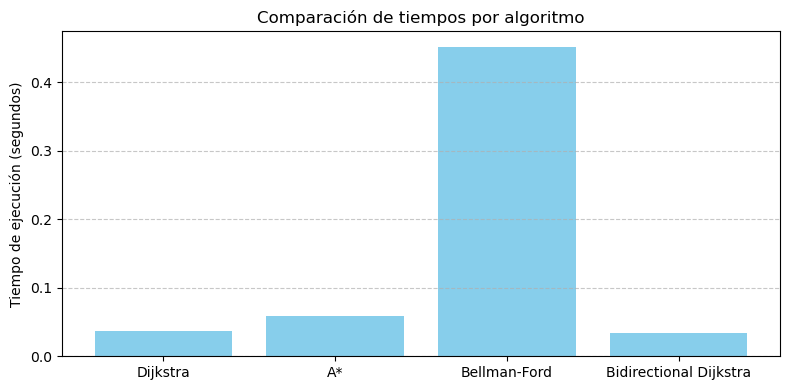

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que tienes este DataFrame:
# df_tiempos = pd.DataFrame([("Dijkstra", 3200, 0.005), ("A*", 3200, 0.003), ...],
#                           columns=["Algoritmo", "Distancia (m)", "Tiempo (s)"])

plt.figure(figsize=(8, 4))
plt.bar(df_tiempos["Algoritmo"], df_tiempos["Tiempo (s)"], color="skyblue")
plt.ylabel("Tiempo de ejecución (segundos)")
plt.title("Comparación de tiempos por algoritmo")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Podemos exportar el grafo con rutas y centralidades a GeoPackage / GeoJSON, para visualizarlo en un software como Qgis o Arcgis.

In [56]:
# Extraer nodos y aristas
nodes, edges = ox.graph_to_gdfs(graph_proj)

# Reproyectar a EPSG:9377 (Bogotá)
edges9377 = edges.to_crs(epsg=9377)
nodes9377 = nodes.to_crs(epsg=9377)

In [57]:
# Exportar aristas y nodos con centralidad al formato GeoPackage
edges9377.to_file("red_bogota_rutas_centralidad.gpkg", layer="edges", driver="GPKG")
nodes9377.to_file("red_bogota_rutas_centralidad.gpkg", layer="nodes", driver="GPKG")

# Alternativamente: exportar como GeoJSON
edges9377.to_file("edges_bogota.geojson", driver="GeoJSON")
nodes9377.to_file("nodes_bogota.geojson", driver="GeoJSON")

Aplicaciones de estos analisis de redes son utiles en planificacion urbana  y movilidad sostenible
ya que ayudan a identificar los barrios mal conectados, detectar cuellos de botella o intersecciones críticas usando centralidad y evaluar la necesidad de infraestructura vial nueva (nuevas calles, puentes, ciclovías).

Acceso a servicios públicos ya que permite identificar el tiempo promedio a hospitales, colegios o centros de abastecimiento desde cada barrio, detectar zonas con bajo acceso o dependencia de una sola ruta.

Son utiles para simular escenarios de evacuación, evaluar cuántas rutas alternativas hay para llegar a puntos seguros o salidas del barrioy priorizar intervenciones en nodos con alta centralidad de intermediación, pues si fallan, afectan todo el sistema.